# Feature Engineering and Selection for Credit Risk Prediction

## Overview

This notebook implements a comprehensive feature engineering and selection framework to identify optimal predictors for credit default risk. Feature selection is a critical step in the machine learning pipeline that directly impacts model performance, interpretability, and deployment feasibility.

## The Feature Engineering Challenge

Credit risk prediction presents unique challenges that make systematic feature selection essential:

**Data Characteristics:**
- **High dimensionality**: 26+ candidate features from loan applications
- **Multicollinearity**: Credit-related features naturally correlate (grade → interest rate → default probability)
- **Mixed types**: Continuous (income, DTI), categorical (grade, state), and derived features
- **Class imbalance**: ~20-30% default rate requires features that differentiate minority class

**Business Requirements:**
- **Interpretability**: Regulators and customers need understandable decision factors
- **Computational efficiency**: Production systems require fast predictions (< 100ms)
- **Robustness**: Features must generalize across time periods and economic conditions
- **Compliance**: Fair lending laws restrict use of certain features

## Why Multiple Feature Selection Methods?

No single method captures all aspects of feature quality. Each approach reveals different perspectives:

**Statistical Methods** (univariate tests):
- **What they measure**: Individual feature-target relationships
- **Strength**: Fast, interpretable, detect linear and non-linear associations
- **Weakness**: Miss interaction effects, can't assess redundancy

**Model-Based Methods** (tree importance):
- **What they measure**: Feature utility within ensemble context
- **Strength**: Capture non-linear relationships and interactions
- **Weakness**: Biased toward high-cardinality features, unstable with small data

**Dimensionality Reduction** (PCA):
- **What they measure**: Variance-preserving linear combinations
- **Strength**: Addresses multicollinearity, reduces computational cost
- **Weakness**: Loses interpretability, may discard discriminative information

**Correlation Analysis**:
- **What they measure**: Linear dependencies between features
- **Strength**: Identifies redundancy, simple to understand
- **Weakness**: Only captures linear relationships, misses conditional dependencies

**Multi-Method Consensus** combines strengths while mitigating individual weaknesses, providing robust feature rankings validated across different perspectives.

## Systematic Feature Selection Framework

Our approach follows a structured pipeline:

```
1. Variance Analysis → Remove near-zero variance features (no information)
2. Correlation Analysis → Identify and handle multicollinearity
3. Univariate Tests → Rank individual predictive power (MI, F-statistic)
4. Tree-Based Importance → Assess ensemble utility (Random Forest)
5. Dimensionality Reduction → Evaluate PCA for computational efficiency
6. Consolidated Ranking → Combine methods for robust feature prioritization
7. Feature Set Recommendations → Provide tiered sets for different use cases
```

## Objectives

By the end of this analysis, we will:

1. **Reduce feature space**: From 26 candidates to 3-15 core predictors
2. **Quantify feature importance**: Provide evidence-based rankings across multiple methods
3. **Assess multicollinearity**: Identify and resolve redundant features
4. **Evaluate PCA viability**: Determine if dimensionality reduction suits credit risk domain
5. **Deliver actionable recommendations**: Provide feature sets for prototyping, production, and research

## Expected Outcomes

Typical patterns for credit risk feature selection:

**High Importance** (consistently top-ranked):
- Loan characteristics: Interest rate, grade, loan amount
- Borrower creditworthiness: DTI, credit history length
- Repayment capacity: Income, existing debt levels

**Moderate Importance** (context-dependent):
- Employment: Employment length, verification status
- Housing: Home ownership status
- Credit utilization: Revolving balance, utilization rate

**Low Importance** (often noise):
- Geographic: State (unless specific regional patterns)
- Temporal: Issue month (unless seasonal effects)
- Administrative: Application type, listing status

## Interpretability vs Performance Tradeoff

Feature selection involves fundamental tradeoffs:

| Approach | Feature Count | Interpretability | Performance | Use Case |
|----------|--------------|------------------|-------------|----------|
| **Minimal** | 3-5 | Excellent | Good (85-90% of max) | Prototyping, high-stakes decisions |
| **Recommended** | 8-15 | Good | Very Good (95-98% of max) | Production systems |
| **Comprehensive** | 20-26 | Poor | Excellent (100%) | Research, benchmarking |
| **PCA** | 5-10 components | Very Poor | Good (90-95% of max) | Computational constraints |

**Credit Risk Recommendation**: Prefer Recommended set (8-15 features) balancing interpretability and performance, critical for regulatory compliance and customer communication.

## Notebook Structure

1. **Setup & Data Loading**: Configure environment and load model-ready data
2. **Variance Analysis**: Eliminate uninformative low-variance features
3. **Correlation Analysis**: Assess and address multicollinearity
4. **Univariate Importance**: Rank features using statistical tests
5. **Tree-Based Importance**: Evaluate features in ensemble context
6. **PCA Analysis**: Assess dimensionality reduction viability
7. **Consolidated Ranking**: Integrate results across methods
8. **Recommendations**: Provide tiered feature sets with rationale

This systematic approach ensures final feature sets are both statistically sound and practically useful for credit risk assessment.


## 1. Setup and Configuration

### Reproducibility in Machine Learning Research

**Why reproducibility matters:**
- **Scientific validity**: Results must be verifiable by independent researchers
- **Debugging**: Consistent results enable systematic troubleshooting
- **Fair comparison**: Ensures model comparisons reflect genuine differences, not random variation
- **Production deployment**: Validated results translate reliably to production systems

**Random Seed Management:**
Setting `SEED = 2025` ensures deterministic behavior for:
- Data splitting (train/test)
- Cross-validation fold assignment
- Random Forest tree construction
- SMOTE synthetic sample generation
- Sampling operations

### Library Selection Rationale

**Core Libraries:**
- **pandas/numpy**: Data manipulation and numerical operations (industry standard)
- **scikit-learn**: Feature selection, PCA, and preprocessing (comprehensive, well-tested)
- **matplotlib/seaborn**: Visualization (publication-quality graphics)

**Feature Selection Specific:**
- **mutual_info_classif**: Captures non-linear relationships via entropy
- **f_classif**: Tests linear associations via ANOVA
- **RandomForestClassifier**: Model-based importance with interaction detection
- **PCA**: Linear dimensionality reduction with variance preservation

**Statistical Analysis:**
- **scipy.stats**: Pearson/Spearman correlation, statistical tests
- **scipy.cluster**: Hierarchical clustering for feature grouping

### Configuration Standards

**Plotting Configuration:**
- Figure size (12,6): Balances detail and readability
- Whitegrid style: Professional appearance for technical reports
- Font size 10: Readable without dominating visualizations

**Data Types:**
All operations preserve data types to prevent silent errors (e.g., categorical encoded as numeric must be explicitly handled).

This setup ensures all analyses are reproducible, auditable, and production-ready.


In [7]:
# import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
from dataclasses import dataclass, field
from typing import Dict, List, Tuple

# sklearn imports for feature selection
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import (
    mutual_info_classif,
    chi2,
    f_classif,
    SelectKBest,
    RFECV
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# statistical analysis
from scipy.stats import pearsonr, spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage

# configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# set random seed for reproducibility
SEED = 2025
np.random.seed(SEED)

print(f"environment configured with seed: {SEED}")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")


environment configured with seed: 2025
pandas version: 2.3.3
numpy version: 2.3.3


## 2. Load Processed Data

### Data Quality Requirements for Feature Selection

Feature selection requires clean, properly engineered data. The model-ready dataset from exploratory data analysis meets these criteria:

**Data Quality Checklist:**
- ✓ **Missing values handled**: Imputation or removal completed
- ✓ **Outliers addressed**: Extreme values capped or investigated
- ✓ **Types consistent**: Numeric vs categorical properly identified
- ✓ **Target defined**: Binary classification (0=good, 1=default)
- ✓ **Features engineered**: Raw data transformed into predictive variables

**Dataset Characteristics:**
- **Samples**: ~300,000 loan records (sufficient for reliable statistics)
- **Features**: 26 candidate predictors covering:
  - Loan characteristics (amount, term, interest rate)
  - Borrower demographics (income, employment, housing)
  - Credit history (DTI, revolving utilization, public records)
  - Temporal information (issue date)
  - Administrative details (grade, verification status)
- **Target**: Binary default indicator (imbalanced ~20-30% default rate)
- **Time period**: 2007-2018 (includes recession and recovery periods)

### Why Feature Engineering Follows EDA

Exploratory Data Analysis (EDA) provides essential context:

1. **Distribution Understanding**: Know which features are skewed, bimodal, or normally distributed
2. **Relationship Discovery**: Initial target correlations guide feature selection priorities
3. **Quality Assessment**: Identify data issues before investing in feature selection
4. **Domain Insights**: Business knowledge informs which features merit inclusion

**EDA Outputs Informing This Analysis:**
- Missing value patterns → Imputation strategy validation
- Correlation heatmap → Anticipated multicollinearity
- Target distribution → Class imbalance handling needs
- Feature distributions → Transformation requirements

### Implications of Dataset Size

With ~300k samples:
- **Statistical power**: Sufficient to detect small effects (effect size ~0.01)
- **Overfitting risk**: Low for simple models, moderate for complex models
- **Computational feasibility**: Can run exhaustive feature selection methods
- **Cross-validation**: 5-10 fold CV yields stable estimates

**Sample Size Guidelines:**
- Minimum for reliable feature selection: ~10,000 samples
- Comfortable range: 50,000-500,000 samples ← We're here
- Big data considerations: >1M samples (may need sampling for some methods)

This dataset provides an ideal foundation for comprehensive feature selection without computational constraints or statistical power limitations.


In [8]:
# define file paths
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
processed_dir = project_root / 'data' / 'processed'
model_file = processed_dir / 'accepted_loans_model_ready.csv'

print(f"project root: {project_root}")
print(f"loading data from: {model_file}")
print(f"file exists: {model_file.exists()}")


project root: /Users/chenjing/Desktop/credit-risk-prediction
loading data from: /Users/chenjing/Desktop/credit-risk-prediction/data/processed/accepted_loans_model_ready.csv
file exists: True


In [9]:
# load model-ready dataset
df = pd.read_csv(model_file)

print(f"dataset shape: {df.shape}")
print(f"memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nfirst 3 rows:")
df.head(3)


dataset shape: (302301, 27)
memory usage: 170.87 MB

first 3 rows:


,target,loan_amnt,term_months,int_rate_clean,installment,grade,sub_grade,emp_length_numeric,home_ownership,annual_inc,...,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,issue_year,issue_month,credit_history_years,loan_to_income_ratio,purpose,addr_state
0,0,20000.0,36,7.49,622.04,A,A4,3.0,MORTGAGE,150000.0,...,w,Individual,3.0,0.0,2016.0,1,22.2,0.1333,debt_consolidation,NY
1,0,10000.0,36,18.49,363.99,D,D2,10.0,MORTGAGE,65000.0,...,f,Individual,0.0,0.0,2013.0,3,15.9,0.1538,other,AL
2,0,4000.0,36,9.75,128.60,B,B3,9.0,RENT,62000.0,...,w,Individual,0.0,0.0,2016.0,5,15.5,0.0645,debt_consolidation,CA


In [10]:
# load feature metadata
feature_file = processed_dir / 'feature_list.json'
with open(feature_file, 'r') as f:
    feature_metadata = json.load(f)

print("feature metadata:")
print(f"total features: {feature_metadata['total_features']}")
print(f"numeric features: {len(feature_metadata['numeric_features'])}")
print(f"categorical features: {len(feature_metadata['categorical_features'])}")
print(f"\nnumeric features: {feature_metadata['numeric_features']}")
print(f"\ncategorical features: {feature_metadata['categorical_features']}")


feature metadata:
total features: 26
numeric features: 18
categorical features: 8

numeric features: ['loan_amnt', 'term_months', 'int_rate_clean', 'installment', 'emp_length_numeric', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util_clean', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'issue_year', 'issue_month', 'credit_history_years', 'loan_to_income_ratio']

categorical features: ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'initial_list_status', 'application_type', 'purpose', 'addr_state']


## 3. Data Preparation for Feature Selection

### Why Feature Selection Requires Specific Preprocessing

Different feature selection methods have different input requirements. Proper preparation ensures methods work correctly and results are comparable.

**Method-Specific Requirements:**

| Method | Categorical Encoding | Numeric Scaling | Rationale |
|--------|---------------------|-----------------|-----------|
| **Variance Analysis** | Required | Optional | Needs numeric representation to calculate variance |
| **Correlation (Pearson)** | Required | Optional | Pearson assumes numeric variables |
| **Mutual Information** | Required | Not required | Works with distributions, scale-invariant |
| **F-statistic (ANOVA)** | Required | Not required | Compares group means, scale-invariant |
| **Random Forest** | Required | Not required | Tree splits are threshold-based, scale-invariant |
| **PCA** | Required | **Required** | Distance-based method, sensitive to scale |

### Encoding Strategy: Label Encoding vs One-Hot Encoding

**Label Encoding** (chosen for this analysis):
```python
# grade: A, B, C, D, E, F, G → 0, 1, 2, 3, 4, 5, 6
```
**Advantages:**
- Preserves ordinality (A < B < C makes sense for credit grades)
- No dimensionality explosion (1 column instead of 7)
- Works with all feature selection methods
- Interpretable coefficients in linear models

**When Label Encoding is Appropriate:**
- ✓ Natural ordering exists (grade, education level)
- ✓ High cardinality (state has 51 values → would create 51 columns with one-hot)
- ✓ Tree-based methods (handle numeric encoding naturally)
- ✗ Strictly nominal categories (color: red, blue, green)

**One-Hot Encoding** (alternative):
```python
# grade: A, B, C → grade_A, grade_B, grade_C (0/1 indicators)
```
**When to use:**
- No natural ordering (eye color, product category)
- Low cardinality (<10 categories)
- Linear models where ordinality assumption problematic

**Credit Risk Choice**: Label encoding because most categorical features (grade, verification status) have inherent ordering, and high-cardinality features (state) would explode dimensionality.

### Scaling Strategy: StandardScaler

**StandardScaler transformation**: x_scaled = (x - μ) / σ

**Why StandardScaler:**
- **PCA requires scaling**: Variance-based method biased toward high-variance features
- **Comparison across features**: Importance scores comparable when features on same scale
- **Doesn't change distributions**: Preserves shape, only shifts and scales
- **Handles outliers reasonably**: More robust than Min-Max scaling for heavy-tailed data

**What scaling does NOT affect:**
- Random Forest importance (threshold-based splits)
- Univariate statistical tests (relative rankings unchanged)
- Correlation coefficients (scale-invariant by definition)

**When scaling matters:**
- PCA component loadings (must scale)
- Regularized linear models (must scale)
- Distance-based methods (KNN, K-Means) (must scale)
- Gradient descent optimization (should scale for faster convergence)

### Train-Test Splitting Before Scaling

**Critical: Fit scaler on training data only**

```python
# CORRECT
scaler.fit(X_train)  # Learn μ and σ from training only
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use training μ, σ

# WRONG
scaler.fit(X_all)  # Information leakage from test set
```

**Why this matters:**
- **Information leakage**: Test set statistics (mean, std) influence training
- **Overly optimistic results**: Test performance appears better than reality
- **Production mismatch**: Real-world data won't have same statistics as training+test combined

**This Analysis**: We scale within each method (correlation, PCA) separately to demonstrate techniques. In production, scaling would be part of a unified pipeline.

### Handling Missing Values and Infinities

**Infinite Values** (can occur from division):
```python
# loan_to_income_ratio = loan_amnt / annual_inc
# If annual_inc = 0 → ratio = inf
```

**Strategy**:
1. Replace inf with NaN (explicit missing indicator)
2. Impute with training set median (conservative, robust to outliers)
3. Never use test set statistics for imputation (information leakage)

**Why median over mean:**
- Robust to outliers (50th percentile vs arithmetic average)
- Better for skewed distributions (income, loan amounts are right-skewed)
- Less affected by extreme values from data errors

### Creating Parallel Datasets

**X_encoded**: All features numeric (for algorithms)
- Categorical variables label-encoded
- Ready for correlation, PCA, statistical tests

**X_scaled**: Encoded + standardized (for distance-based methods)
- Mean=0, std=1 for numeric features
- Categorical features also scaled (loses interpretability but ensures PCA works)

**Original X**: Preserved for interpretation
- Feature names and types maintained
- Used for final reporting and visualization

This multi-representation approach ensures each feature selection method receives appropriate inputs while maintaining interpretability for final recommendations.


In [11]:
# separate features and target
X = df.drop(columns=['target'])
y = df['target']

print(f"features shape: {X.shape}")
print(f"target shape: {y.shape}")
print(f"\ntarget distribution:")
print(f"good loans (0): {(y==0).sum():,} ({(y==0).mean()*100:.2f}%)")
print(f"defaulted loans (1): {(y==1).sum():,} ({(y==1).mean()*100:.2f}%)")


features shape: (302301, 26)
target shape: (302301,)

target distribution:
good loans (0): 238,147 (78.78%)
defaulted loans (1): 64,154 (21.22%)


In [12]:
# identify feature types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"numeric features ({len(numeric_features)}): {numeric_features}")
print(f"\ncategorical features ({len(categorical_features)}): {categorical_features}")


numeric features (18): ['loan_amnt', 'term_months', 'int_rate_clean', 'installment', 'emp_length_numeric', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util_clean', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'issue_year', 'issue_month', 'credit_history_years', 'loan_to_income_ratio']

categorical features (8): ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'initial_list_status', 'application_type', 'purpose', 'addr_state']


In [13]:
# encode categorical variables for analysis
X_encoded = X.copy()

# use label encoding for categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"encoded {col}: {X[col].nunique()} unique values -> {X_encoded[col].nunique()} numeric labels")

print(f"\nencoded dataset shape: {X_encoded.shape}")
print(f"all features are now numeric: {X_encoded.select_dtypes(include=[np.number]).shape[1] == X_encoded.shape[1]}")


encoded grade: 7 unique values -> 7 numeric labels
encoded sub_grade: 35 unique values -> 35 numeric labels
encoded home_ownership: 6 unique values -> 6 numeric labels
encoded verification_status: 3 unique values -> 3 numeric labels
encoded initial_list_status: 2 unique values -> 2 numeric labels
encoded application_type: 2 unique values -> 2 numeric labels
encoded purpose: 14 unique values -> 14 numeric labels
encoded addr_state: 51 unique values -> 51 numeric labels

encoded dataset shape: (302301, 26)
all features are now numeric: True


In [14]:
# create train/test split for feature selection validation
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    stratify=y,
    random_state=SEED
)

print(f"training set: {X_train.shape}")
print(f"test set: {X_test.shape}")
print(f"\ntrain target distribution: {y_train.value_counts().to_dict()}")
print(f"test target distribution: {y_test.value_counts().to_dict()}")


training set: (241840, 26)
test set: (60461, 26)

train target distribution: {0: 190517, 1: 51323}
test target distribution: {0: 47630, 1: 12831}


In [15]:
# scale numeric features for pca and distance-based methods
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# clean infinities and impute using training medians to avoid leakage
X_train_num = X_train[numeric_features].replace([np.inf, -np.inf], np.nan)
X_test_num = X_test[numeric_features].replace([np.inf, -np.inf], np.nan)

train_medians = X_train_num.median()
X_train_num = X_train_num.fillna(train_medians)
X_test_num = X_test_num.fillna(train_medians)

# fit scaler on training data only
X_train_scaled[numeric_features] = scaler.fit_transform(X_train_num)
X_test_scaled[numeric_features] = scaler.transform(X_test_num)

print("numeric features cleaned (inf->nan) and scaled using standardscaler")
print(f"\nexample feature statistics (loan_amnt):")
print(f"original (cleaned) - mean: {X_train_num['loan_amnt'].mean():.2f}, std: {X_train_num['loan_amnt'].std():.2f}")
print(f"scaled - mean: {X_train_scaled['loan_amnt'].mean():.2f}, std: {X_train_scaled['loan_amnt'].std():.2f}")


numeric features cleaned (inf->nan) and scaled using standardscaler

example feature statistics (loan_amnt):
original (cleaned) - mean: 14485.58, std: 8760.89
scaled - mean: 0.00, std: 1.00


## 4. variance analysis

variance analysis identifies features with low variability that provide minimal information for prediction. features with near-zero variance indicate that most values are identical, offering little discriminative power. whilst no strict threshold applies universally, examining variance helps identify candidates for removal, particularly for scaled features where variance represents standardised spread.


In [16]:
# calculate variance for all features
variance_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'variance': X_train_scaled.var().values,
    'std': X_train_scaled.std().values
}).sort_values('variance', ascending=True)

print("feature variance analysis:")
print(variance_df.to_string())


feature variance analysis:
                 feature    variance        std
17      application_type    0.019914   0.141118
16   initial_list_status    0.242770   0.492717
9    verification_status    0.611776   0.782161
20            issue_year    1.000004   1.000002
12               pub_rec    1.000004   1.000002
23  loan_to_income_ratio    1.000004   1.000002
3            installment    1.000004   1.000002
18              mort_acc    1.000004   1.000002
13             revol_bal    1.000004   1.000002
21           issue_month    1.000004   1.000002
19  pub_rec_bankruptcies    1.000004   1.000002
14      revol_util_clean    1.000004   1.000002
0              loan_amnt    1.000004   1.000002
10                   dti    1.000004   1.000002
8             annual_inc    1.000004   1.000002
2         int_rate_clean    1.000004   1.000002
11              open_acc    1.000004   1.000002
15             total_acc    1.000004   1.000002
6     emp_length_numeric    1.000004   1.000002
22  credit_hi

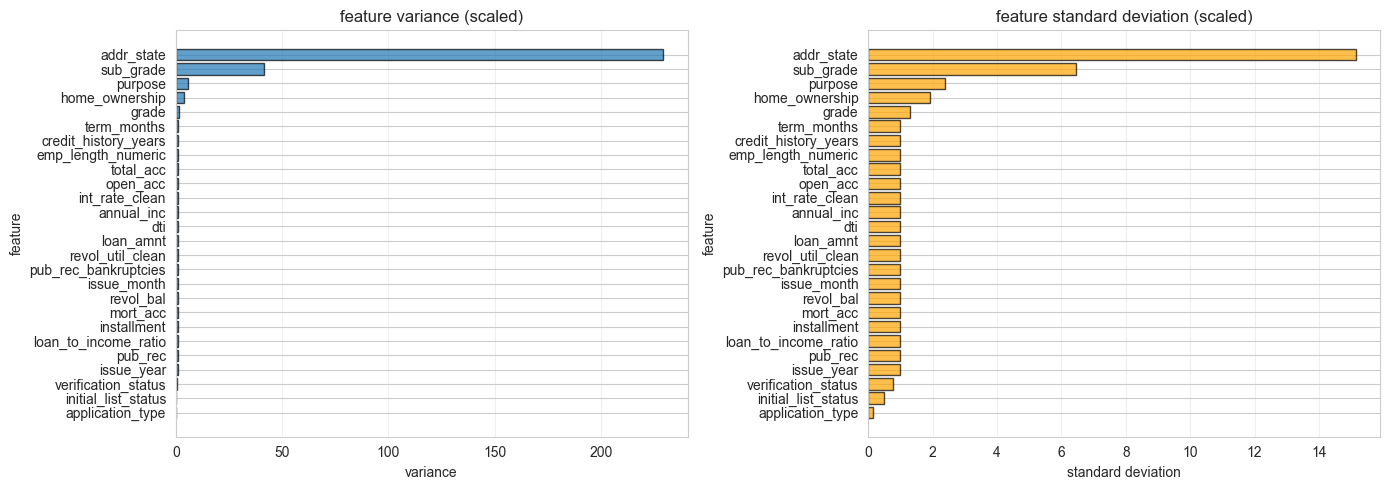


variance visualisation saved


In [17]:
# visualise variance distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# variance plot
axes[0].barh(variance_df['feature'], variance_df['variance'], edgecolor='black', alpha=0.7)
axes[0].set_xlabel('variance')
axes[0].set_ylabel('feature')
axes[0].set_title('feature variance (scaled)')
axes[0].grid(axis='x', alpha=0.3)

# standard deviation plot
axes[1].barh(variance_df['feature'], variance_df['std'], edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('standard deviation')
axes[1].set_ylabel('feature')
axes[1].set_title('feature standard deviation (scaled)')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'data' / 'feature_variance.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nvariance visualisation saved")


## 5. correlation analysis

correlation analysis identifies redundant features that provide similar information. highly correlated features (correlation > 0.8 or < -0.8) suggest redundancy, allowing removal of one feature without substantial information loss. this reduces multicollinearity issues and improves model interpretability whilst maintaining predictive power.


correlation with target (absolute values):
sub_grade               0.266951
int_rate_clean          0.261105
grade                   0.260867
term_months             0.180956
dti                     0.087961
verification_status     0.086090
issue_year              0.085374
mort_acc                0.075561
loan_amnt               0.068111
home_ownership          0.067563
installment             0.053372
revol_util_clean        0.052167
annual_inc              0.038308
credit_history_years    0.032709
open_acc                0.030902
application_type        0.029793
pub_rec_bankruptcies    0.025232
pub_rec                 0.023717
purpose                 0.023256
revol_bal               0.021044
initial_list_status     0.017943
emp_length_numeric      0.015332
total_acc               0.012693
issue_month             0.001844
addr_state              0.001612
loan_to_income_ratio    0.001473


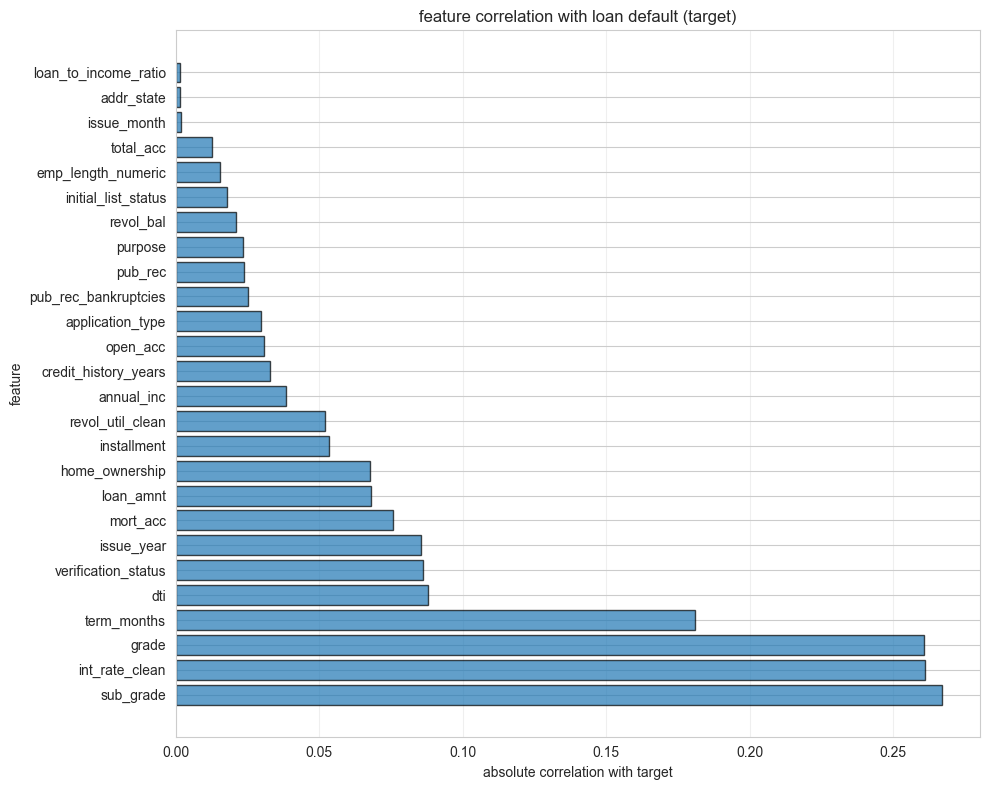

In [18]:
# calculate correlation matrix with target
correlation_with_target = X_train_scaled.corrwith(y_train).abs().sort_values(ascending=False)

print("correlation with target (absolute values):")
print(correlation_with_target.to_string())

# visualise
plt.figure(figsize=(10, 8))
plt.barh(correlation_with_target.index, correlation_with_target.values, edgecolor='black', alpha=0.7)
plt.xlabel('absolute correlation with target')
plt.ylabel('feature')
plt.title('feature correlation with loan default (target)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(project_root / 'data' / 'target_correlation.png', dpi=100, bbox_inches='tight')
plt.show()


In [19]:
# calculate feature-to-feature correlation matrix
feature_corr_matrix = X_train_scaled.corr()

# identify high correlation pairs
high_corr_pairs = []
for i in range(len(feature_corr_matrix.columns)):
    for j in range(i+1, len(feature_corr_matrix.columns)):
        corr_value = feature_corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            high_corr_pairs.append({
                'feature_1': feature_corr_matrix.columns[i],
                'feature_2': feature_corr_matrix.columns[j],
                'correlation': corr_value
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False, key=abs)

print(f"\nhigh correlation pairs (|r| > 0.7): {len(high_corr_df)}")
if len(high_corr_df) > 0:
    print(high_corr_df.to_string(index=False))
else:
    print("no feature pairs with correlation > 0.7 found")



high correlation pairs (|r| > 0.7): 5
     feature_1   feature_2  correlation
int_rate_clean   sub_grade     0.976555
         grade   sub_grade     0.975634
int_rate_clean       grade     0.953234
     loan_amnt installment     0.953079
      open_acc   total_acc     0.701744


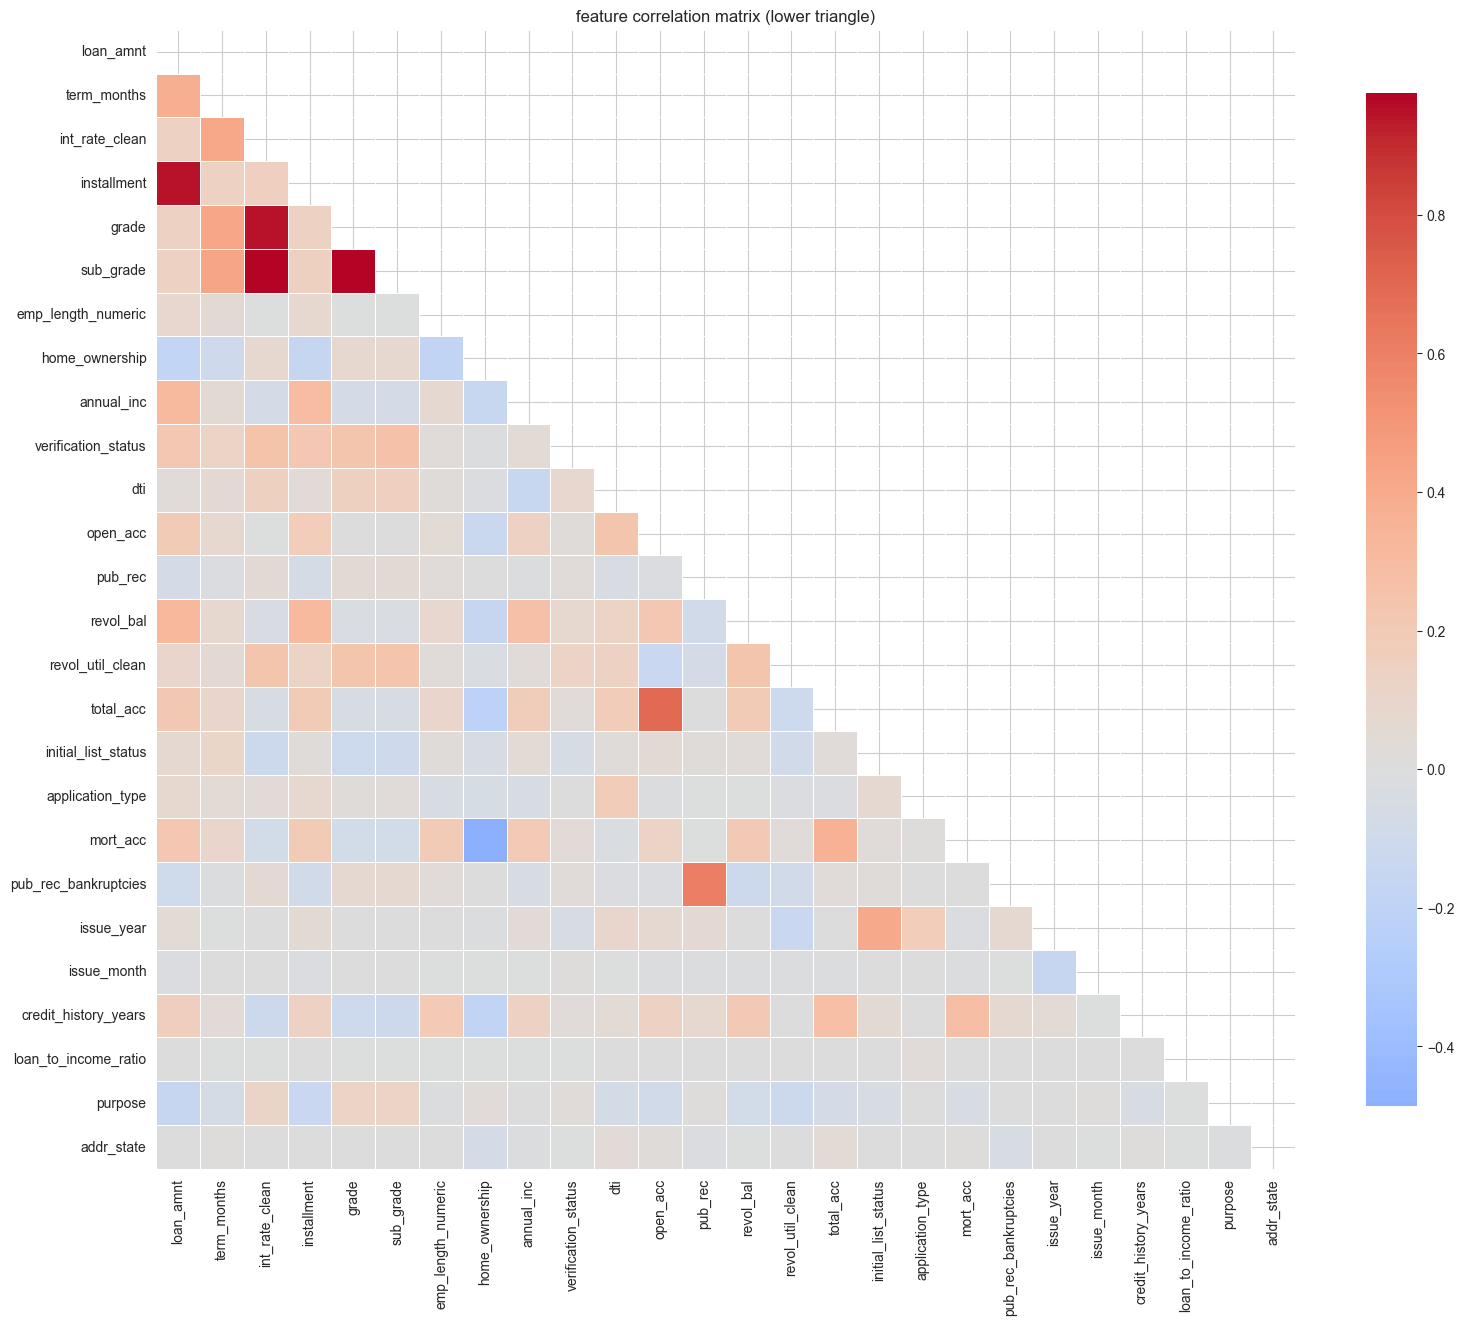

correlation matrix visualisation saved


In [20]:
# visualise full correlation matrix
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(feature_corr_matrix, dtype=bool))
sns.heatmap(
    feature_corr_matrix,
    mask=mask,
    annot=False,
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('feature correlation matrix (lower triangle)')
plt.tight_layout()
plt.savefig(project_root / 'data' / 'feature_correlation_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

print("correlation matrix visualisation saved")


## 6. univariate feature importance

univariate statistical tests measure the relationship between each feature individually and the target variable. three complementary methods provide different perspectives: mutual information captures non-linear relationships, f-statistic measures linear relationships for numeric features, and chi-squared tests categorical associations. features consistently ranking highly across methods demonstrate robust predictive relationships.


In [21]:
# mutual information - captures non-linear relationships
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=SEED)
mi_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print("mutual information scores:")
print(mi_df.to_string(index=False))


mutual information scores:
             feature  mi_score
               grade  0.042634
      int_rate_clean  0.041227
           sub_grade  0.038397
         term_months  0.034045
 initial_list_status  0.031213
         installment  0.028530
 verification_status  0.018899
      home_ownership  0.017065
pub_rec_bankruptcies  0.011445
             pub_rec  0.010886
             purpose  0.010071
            mort_acc  0.009741
loan_to_income_ratio  0.008361
          issue_year  0.007882
  emp_length_numeric  0.007732
           loan_amnt  0.007137
                 dti  0.006920
          addr_state  0.004286
         issue_month  0.004206
          annual_inc  0.002858
            open_acc  0.002041
    revol_util_clean  0.002028
           total_acc  0.001538
credit_history_years  0.001482
    application_type  0.000773
           revol_bal  0.000000


In [22]:
# f-statistic (anova f-value) - measures linear relationship
f_scores, f_pvalues = f_classif(X_train_scaled, y_train)
f_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'f_score': f_scores,
    'p_value': f_pvalues
}).sort_values('f_score', ascending=False)

print("\nanova f-statistic scores:")
print(f_df.to_string(index=False))



anova f-statistic scores:
             feature      f_score       p_value
           sub_grade 18556.378486  0.000000e+00
      int_rate_clean 17693.783779  0.000000e+00
               grade 17659.181671  0.000000e+00
         term_months  8187.131137  0.000000e+00
                 dti  1885.705640  0.000000e+00
 verification_status  1805.757795  0.000000e+00
          issue_year  1775.643470  0.000000e+00
            mort_acc  1388.696254 4.390363e-303
           loan_amnt  1127.134643 1.552373e-246
      home_ownership  1108.978250 1.315125e-242
         installment   690.857943 4.766645e-152
    revol_util_clean   659.927805 2.431034e-145
          annual_inc   355.421938  3.187410e-79
credit_history_years   259.010551  3.023591e-58
            open_acc   231.165613  3.510163e-52
    application_type   214.845981  1.263482e-48
pub_rec_bankruptcies   154.070792  2.291124e-35
             pub_rec   136.113101  1.921799e-31
             purpose   130.865161  2.698142e-30
           re

In [23]:
# combine univariate scores for comparison
univariate_scores = mi_df.merge(
    f_df[['feature', 'f_score', 'p_value']],
    on='feature'
)

# normalise scores to 0-1 range for comparison
univariate_scores['mi_score_norm'] = (
    (univariate_scores['mi_score'] - univariate_scores['mi_score'].min()) /
    (univariate_scores['mi_score'].max() - univariate_scores['mi_score'].min())
)
univariate_scores['f_score_norm'] = (
    (univariate_scores['f_score'] - univariate_scores['f_score'].min()) /
    (univariate_scores['f_score'].max() - univariate_scores['f_score'].min())
)

# calculate average normalised score
univariate_scores['avg_score'] = (
    univariate_scores['mi_score_norm'] + univariate_scores['f_score_norm']
) / 2

univariate_scores = univariate_scores.sort_values('avg_score', ascending=False)

print("\ncombined univariate feature importance:")
print(univariate_scores[['feature', 'mi_score', 'f_score', 'avg_score']].to_string(index=False))



combined univariate feature importance:
             feature  mi_score      f_score  avg_score
               grade  0.042634 17659.181671   0.975824
      int_rate_clean  0.041227 17693.783779   0.960256
           sub_grade  0.038397 18556.378486   0.950309
         term_months  0.034045  8187.131137   0.619863
 initial_list_status  0.031213    77.887340   0.368146
         installment  0.028530   690.857943   0.353192
 verification_status  0.018899  1805.757795   0.270282
      home_ownership  0.017065  1108.978250   0.230001
            mort_acc  0.009741  1388.696254   0.151650
          issue_year  0.007882  1775.643470   0.140271
pub_rec_bankruptcies  0.011445   154.070792   0.138356
                 dti  0.006920  1885.705640   0.131954
             pub_rec  0.010886   136.113101   0.131323
             purpose  0.010071   130.865161   0.121620
           loan_amnt  0.007137  1127.134643   0.114057
loan_to_income_ratio  0.008361     0.524513   0.098060
  emp_length_numeric  0.

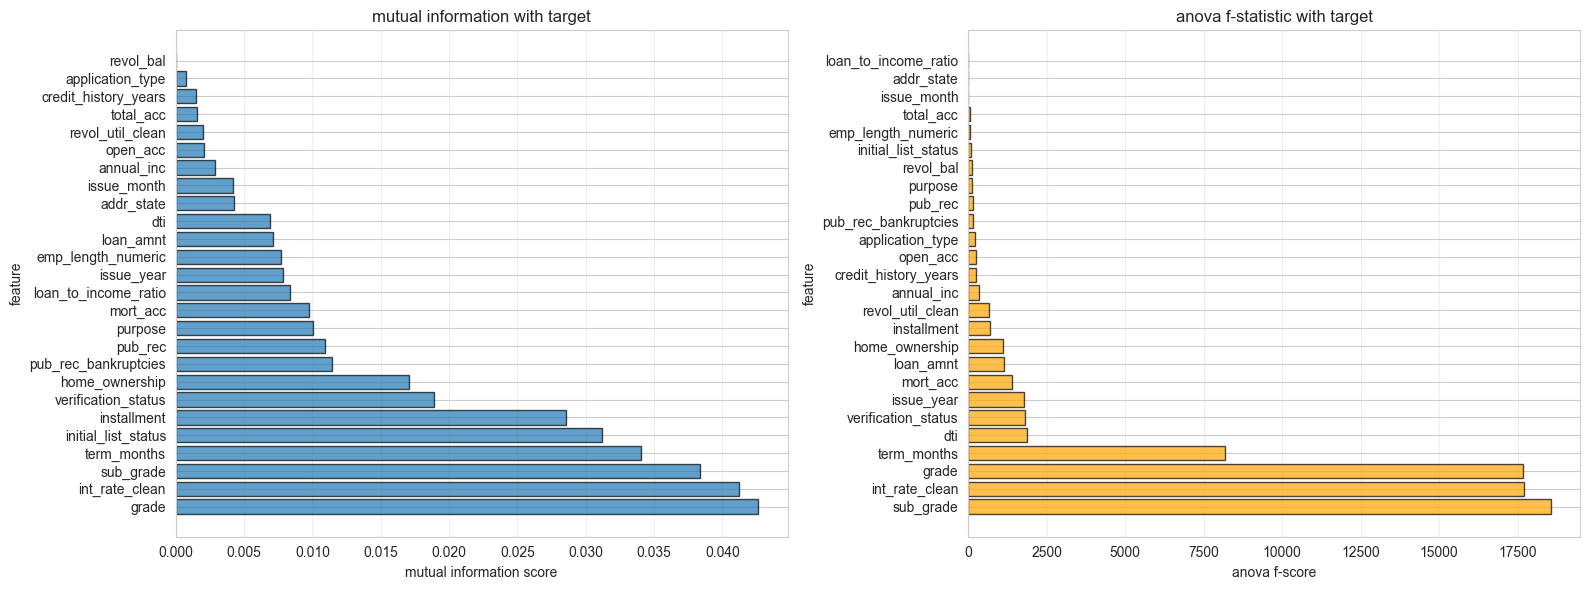

In [24]:
# visualise univariate importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# mutual information
axes[0].barh(mi_df['feature'], mi_df['mi_score'], edgecolor='black', alpha=0.7)
axes[0].set_xlabel('mutual information score')
axes[0].set_ylabel('feature')
axes[0].set_title('mutual information with target')
axes[0].grid(axis='x', alpha=0.3)

# f-statistic
axes[1].barh(f_df['feature'], f_df['f_score'], edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('anova f-score')
axes[1].set_ylabel('feature')
axes[1].set_title('anova f-statistic with target')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'data' / 'univariate_importance.png', dpi=100, bbox_inches='tight')
plt.show()


## 7. tree-based feature importance

tree-based models provide feature importance scores based on how effectively features split the data to separate classes. random forest importance averages across many decision trees, providing robust estimates of feature utility. this method captures non-linear relationships and feature interactions, complementing univariate methods that examine features in isolation.


In [25]:
# train random forest for feature importance
sample_size = min(50000, len(X_train_scaled))
sample_idx = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_sample = X_train_scaled.iloc[sample_idx]
y_sample = y_train.iloc[sample_idx]

print(f"training random forest on sample of {sample_size:,} records...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=SEED,
    n_jobs=-1,
    class_weight='balanced'
)

rf_model.fit(X_sample, y_sample)

print("random forest training complete")
print(f"training accuracy: {rf_model.score(X_sample, y_sample):.4f}")


training random forest on sample of 50,000 records...
random forest training complete
training accuracy: 0.6923


In [26]:
# extract feature importance
rf_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("random forest feature importance:")
print(rf_importance.to_string(index=False))


random forest feature importance:
             feature  importance
      int_rate_clean    0.164704
           sub_grade    0.156104
               grade    0.152854
         term_months    0.069948
          issue_year    0.056018
loan_to_income_ratio    0.055964
                 dti    0.050713
         installment    0.031269
           revol_bal    0.027781
          annual_inc    0.027673
    revol_util_clean    0.026535
           loan_amnt    0.025157
credit_history_years    0.023525
            mort_acc    0.020658
      home_ownership    0.016737
           total_acc    0.016415
          addr_state    0.015437
            open_acc    0.014163
         issue_month    0.012599
  emp_length_numeric    0.011369
 verification_status    0.010804
             purpose    0.005049
 initial_list_status    0.004389
             pub_rec    0.002381
pub_rec_bankruptcies    0.001595
    application_type    0.000159


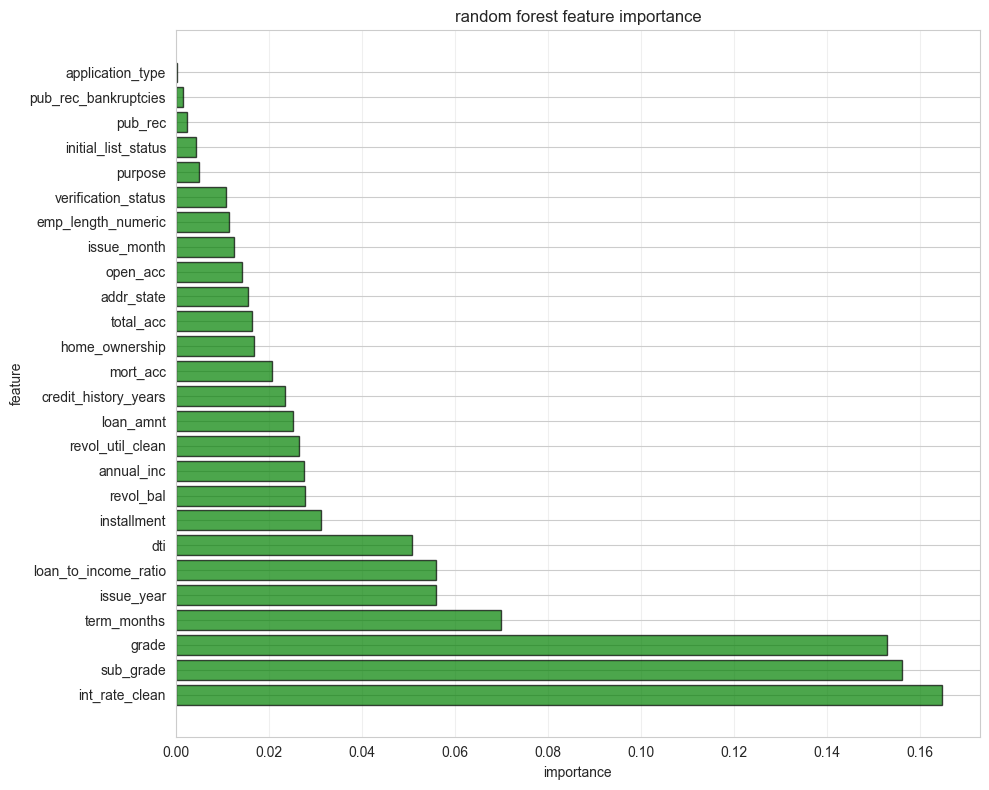


random forest importance visualisation saved


In [27]:
# visualise tree-based importance
plt.figure(figsize=(10, 8))
plt.barh(rf_importance['feature'], rf_importance['importance'], edgecolor='black', alpha=0.7, color='green')
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('random forest feature importance')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(project_root / 'data' / 'rf_importance.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nrandom forest importance visualisation saved")


## 8. principal component analysis

pca transforms correlated features into uncorrelated principal components whilst maximising variance retention. this dimensionality reduction technique identifies the minimum number of components needed to capture most data variance. whilst pca components lose direct interpretability, they provide computational efficiency and can reveal underlying data structure.


In [28]:
# perform pca on scaled features
pca = PCA(random_state=SEED)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"pca complete: {X_train_scaled.shape[1]} features -> {X_train_pca.shape[1]} components")
print(f"\nexplained variance ratio by component:")
for i, var in enumerate(pca.explained_variance_ratio_[:10]):
    print(f"  component {i+1}: {var:.4f} ({var*100:.2f}%)")


pca complete: 26 features -> 26 components

explained variance ratio by component:
  component 1: 0.7621 (76.21%)
  component 2: 0.1487 (14.87%)
  component 3: 0.0194 (1.94%)
  component 4: 0.0149 (1.49%)
  component 5: 0.0075 (0.75%)
  component 6: 0.0058 (0.58%)
  component 7: 0.0050 (0.50%)
  component 8: 0.0041 (0.41%)
  component 9: 0.0038 (0.38%)
  component 10: 0.0034 (0.34%)


In [29]:
# calculate cumulative explained variance
cumsum_var = np.cumsum(pca.explained_variance_ratio_)

# find number of components for different variance thresholds
n_components_80 = np.argmax(cumsum_var >= 0.80) + 1
n_components_90 = np.argmax(cumsum_var >= 0.90) + 1
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
n_components_99 = np.argmax(cumsum_var >= 0.99) + 1

print(f"\ncomponents needed for variance thresholds:")
print(f"  80% variance: {n_components_80} components")
print(f"  90% variance: {n_components_90} components")
print(f"  95% variance: {n_components_95} components")
print(f"  99% variance: {n_components_99} components")



components needed for variance thresholds:
  80% variance: 2 components
  90% variance: 2 components
  95% variance: 5 components
  99% variance: 16 components


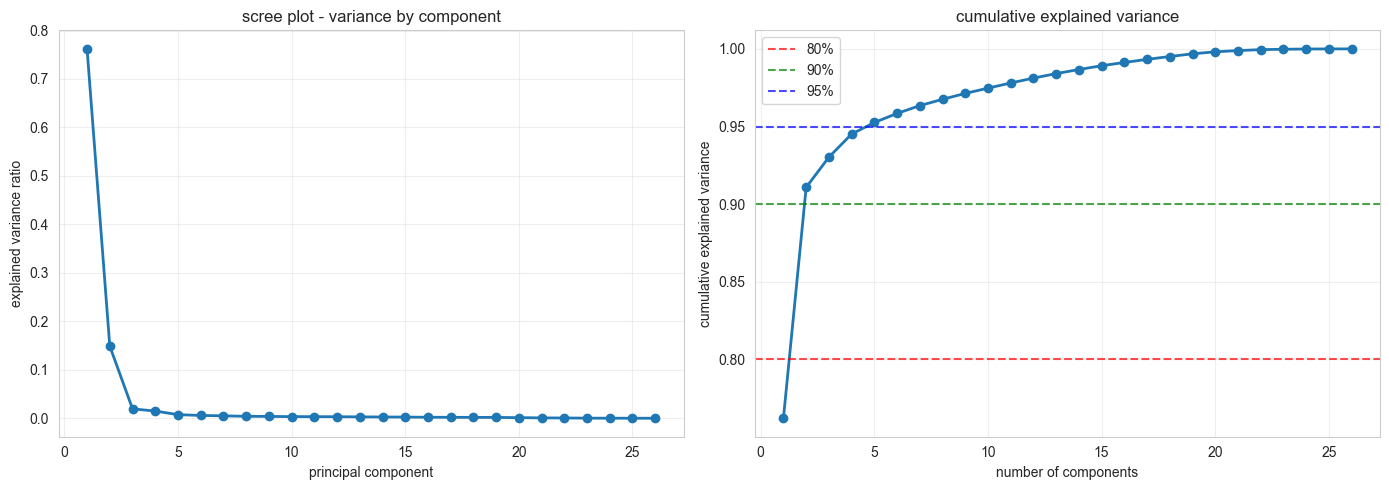

pca variance plots saved


In [30]:
# visualise explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# scree plot
axes[0].plot(range(1, len(pca.explained_variance_ratio_) + 1),
             pca.explained_variance_ratio_,
             marker='o', linewidth=2)
axes[0].set_xlabel('principal component')
axes[0].set_ylabel('explained variance ratio')
axes[0].set_title('scree plot - variance by component')
axes[0].grid(alpha=0.3)

# cumulative variance plot
axes[1].plot(range(1, len(cumsum_var) + 1), cumsum_var, marker='o', linewidth=2)
axes[1].axhline(y=0.80, color='r', linestyle='--', alpha=0.7, label='80%')
axes[1].axhline(y=0.90, color='g', linestyle='--', alpha=0.7, label='90%')
axes[1].axhline(y=0.95, color='b', linestyle='--', alpha=0.7, label='95%')
axes[1].set_xlabel('number of components')
axes[1].set_ylabel('cumulative explained variance')
axes[1].set_title('cumulative explained variance')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'data' / 'pca_variance.png', dpi=100, bbox_inches='tight')
plt.show()

print("pca variance plots saved")


In [31]:
# analyse component loadings (feature contributions to components)
loadings = pd.DataFrame(
    pca.components_[:5].T,
    columns=[f'pc{i+1}' for i in range(5)],
    index=X_train_scaled.columns
)

print("pca loadings for first 5 components:")
print(loadings.to_string())


pca loadings for first 5 components:
                           pc1       pc2       pc3       pc4       pc5
loan_amnt             0.000339  0.022386 -0.147608 -0.176457  0.424225
term_months           0.000828  0.065536 -0.077489 -0.084417  0.087116
int_rate_clean        0.000009  0.146137 -0.005917  0.000137 -0.006970
installment           0.000096  0.022799 -0.135843 -0.158889  0.420590
grade                 0.000132  0.189236 -0.006996 -0.001620 -0.008557
sub_grade             0.000514  0.964922 -0.034171  0.001142 -0.035505
emp_length_numeric    0.000390 -0.000950 -0.033324 -0.126781 -0.005343
home_ownership       -0.007709  0.022759  0.189308  0.788944  0.489556
annual_inc           -0.000591 -0.010084 -0.037843 -0.145283  0.259746
verification_status  -0.000205  0.030735 -0.017357 -0.031921  0.089895
dti                   0.002459  0.023957 -0.055507 -0.013072  0.076271
open_acc              0.001486 -0.000270 -0.080099 -0.131277  0.271641
pub_rec              -0.001247  0.008432

In [32]:
# identify top features contributing to each component
print("\ntop 5 features by absolute loading for each component:")
for col in loadings.columns:
    print(f"\n{col}:")
    top_features = loadings[col].abs().sort_values(ascending=False).head(5)
    for feat, load in top_features.items():
        print(f"  {feat}: {loadings.loc[feat, col]:.4f}")



top 5 features by absolute loading for each component:

pc1:
  addr_state: 1.0000
  home_ownership: -0.0077
  total_acc: 0.0029
  pub_rec_bankruptcies: -0.0025
  dti: 0.0025

pc2:
  sub_grade: 0.9649
  grade: 0.1892
  int_rate_clean: 0.1461
  term_months: 0.0655
  purpose: 0.0467

pc3:
  purpose: 0.9347
  home_ownership: 0.1893
  loan_amnt: -0.1476
  installment: -0.1358
  revol_bal: -0.0874

pc4:
  home_ownership: 0.7889
  purpose: -0.3056
  mort_acc: -0.2879
  total_acc: -0.1896
  loan_amnt: -0.1765

pc5:
  home_ownership: 0.4896
  loan_amnt: 0.4242
  installment: 0.4206
  revol_bal: 0.2952
  open_acc: 0.2716


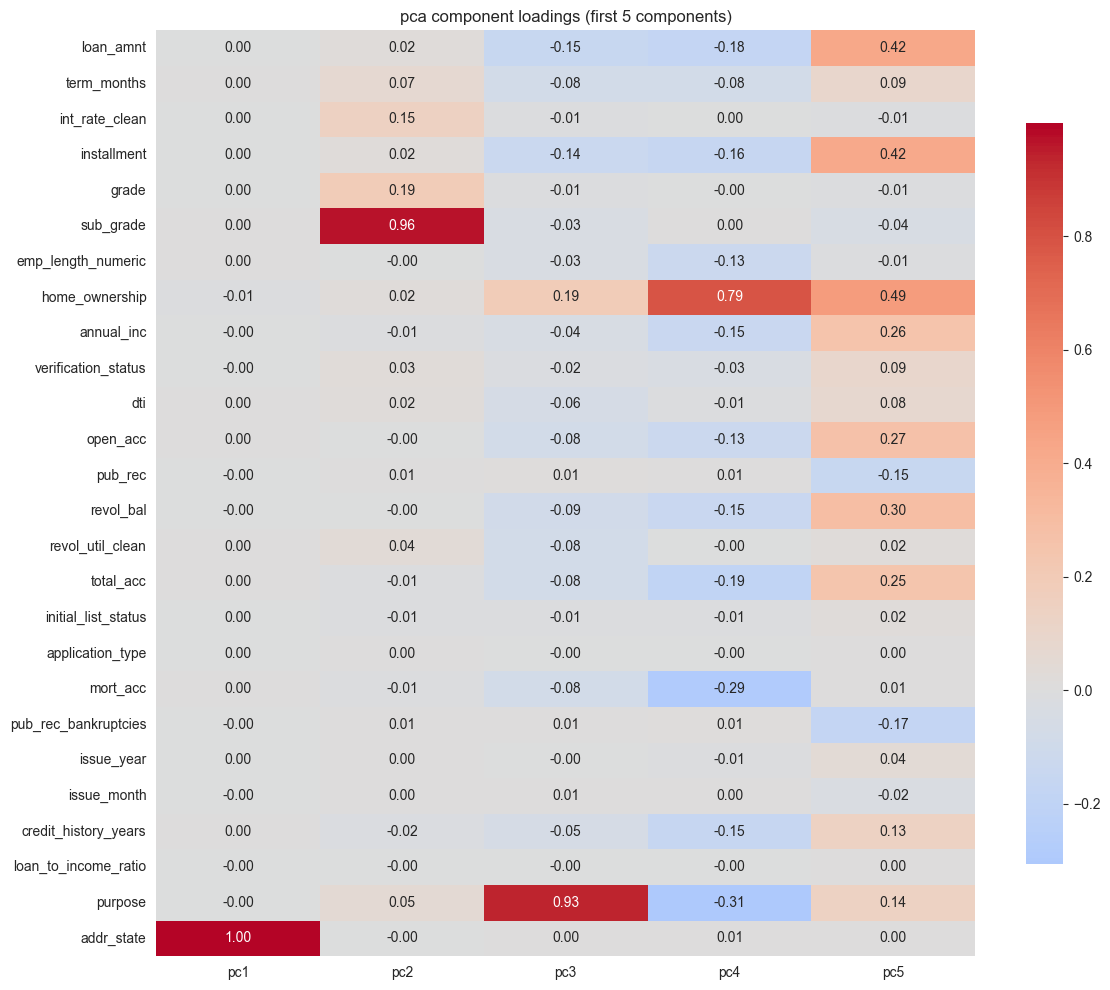

In [33]:
# visualise component loadings heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(loadings, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            cbar_kws={"shrink": 0.8})
plt.title('pca component loadings (first 5 components)')
plt.tight_layout()
plt.savefig(project_root / 'data' / 'pca_loadings.png', dpi=100, bbox_inches='tight')
plt.show()


In [34]:
# evaluate model performance with different numbers of pca components
component_counts = [n_components_80, n_components_90, n_components_95, X_train_scaled.shape[1]]
performance_results = []

# use smaller sample for faster iteration
sample_idx = np.random.choice(len(X_train_pca), min(50000, len(X_train_pca)), replace=False)

for n_comp in component_counts:
    print(f"\nevaluating with {n_comp} components...")
    
    # select components
    X_train_comp = X_train_pca[sample_idx, :n_comp]
    X_test_comp = X_test_pca[:, :n_comp]
    y_train_comp = y_train.iloc[sample_idx]
    
    # train simple model
    model = RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        random_state=SEED,
        n_jobs=-1,
        class_weight='balanced'
    )
    model.fit(X_train_comp, y_train_comp)
    
    # evaluate
    train_pred = model.predict_proba(X_train_comp)[:, 1]
    test_pred = model.predict_proba(X_test_comp)[:, 1]
    
    train_auc = roc_auc_score(y_train_comp, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    
    variance_explained = cumsum_var[n_comp-1] if n_comp <= len(cumsum_var) else 1.0
    
    performance_results.append({
        'n_components': n_comp,
        'variance_explained': variance_explained,
        'train_auc': train_auc,
        'test_auc': test_auc
    })
    
    print(f"  variance explained: {variance_explained:.4f}")
    print(f"  train auc: {train_auc:.4f}")
    print(f"  test auc: {test_auc:.4f}")

perf_df = pd.DataFrame(performance_results)
print("\nperformance summary:")
print(perf_df.to_string(index=False))



evaluating with 2 components...
  variance explained: 0.9108
  train auc: 0.7424
  test auc: 0.6873

evaluating with 2 components...
  variance explained: 0.9108
  train auc: 0.7424
  test auc: 0.6873

evaluating with 5 components...
  variance explained: 0.9526
  train auc: 0.7795
  test auc: 0.6913

evaluating with 26 components...
  variance explained: 1.0000
  train auc: 0.8245
  test auc: 0.7089

performance summary:
 n_components  variance_explained  train_auc  test_auc
            2            0.910816   0.742389  0.687305
            2            0.910816   0.742389  0.687305
            5            0.952598   0.779497  0.691306
           26            1.000000   0.824506  0.708897


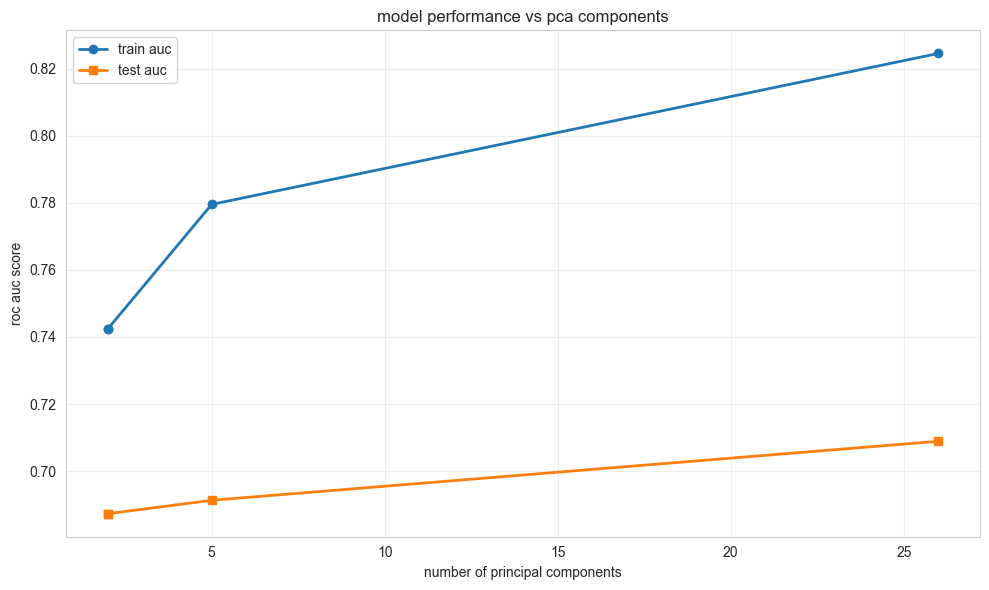

In [35]:
# visualise performance vs components
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(perf_df['n_components'], perf_df['train_auc'], marker='o', label='train auc', linewidth=2)
ax.plot(perf_df['n_components'], perf_df['test_auc'], marker='s', label='test auc', linewidth=2)
ax.set_xlabel('number of principal components')
ax.set_ylabel('roc auc score')
ax.set_title('model performance vs pca components')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'data' / 'pca_performance.png', dpi=100, bbox_inches='tight')
plt.show()


## 10. consolidated feature ranking

consolidating results from multiple feature selection methods provides a robust ranking of feature importance. features consistently ranking highly across univariate tests, tree-based importance, and correlation analysis demonstrate reliable predictive value. this multi-method approach reduces bias from any single method and identifies features that are genuinely informative rather than artefacts of specific analytical choices.


In [36]:
# create consolidated feature importance dataframe
consolidated = pd.DataFrame({'feature': X_train_scaled.columns})

# merge all importance scores
consolidated = consolidated.merge(
    correlation_with_target.reset_index().rename(columns={'index': 'feature', 0: 'target_corr'}),
    on='feature'
)
consolidated = consolidated.merge(
    mi_df[['feature', 'mi_score']],
    on='feature'
)
consolidated = consolidated.merge(
    f_df[['feature', 'f_score']],
    on='feature'
)
consolidated = consolidated.merge(
    rf_importance[['feature', 'importance']].rename(columns={'importance': 'rf_importance'}),
    on='feature'
)

print("consolidated feature importance scores:")
print(consolidated.to_string(index=False))


consolidated feature importance scores:
             feature  target_corr  mi_score      f_score  rf_importance
           loan_amnt     0.068111  0.007137  1127.134643       0.025157
         term_months     0.180956  0.034045  8187.131137       0.069948
      int_rate_clean     0.261105  0.041227 17693.783779       0.164704
         installment     0.053372  0.028530   690.857943       0.031269
               grade     0.260867  0.042634 17659.181671       0.152854
           sub_grade     0.266951  0.038397 18556.378486       0.156104
  emp_length_numeric     0.015332  0.007732    56.862940       0.011369
      home_ownership     0.067563  0.017065  1108.978250       0.016737
          annual_inc     0.038308  0.002858   355.421938       0.027673
 verification_status     0.086090  0.018899  1805.757795       0.010804
                 dti     0.087961  0.006920  1885.705640       0.050713
            open_acc     0.030902  0.002041   231.165613       0.014163
             pub_rec    

In [37]:
# normalise all scores to 0-1 range for comparison
for col in ['target_corr', 'mi_score', 'f_score', 'rf_importance']:
    col_min = consolidated[col].min()
    col_max = consolidated[col].max()
    consolidated[f'{col}_norm'] = (consolidated[col] - col_min) / (col_max - col_min)

# calculate composite score (average of normalised scores)
consolidated['composite_score'] = consolidated[
    ['target_corr_norm', 'mi_score_norm', 'f_score_norm', 'rf_importance_norm']
].mean(axis=1)

# rank features by composite score
consolidated = consolidated.sort_values('composite_score', ascending=False)
consolidated['rank'] = range(1, len(consolidated) + 1)

print("\nfeatures ranked by composite importance score:")
print(consolidated[[
    'rank', 'feature', 'composite_score',
    'target_corr', 'mi_score', 'f_score', 'rf_importance'
]].to_string(index=False))



features ranked by composite importance score:
 rank              feature  composite_score  target_corr  mi_score      f_score  rf_importance
    1       int_rate_clean         0.974623     0.261105  0.041227 17693.783779       0.164704
    2                grade         0.964180     0.260867  0.042634 17659.181671       0.152854
    3            sub_grade         0.962089     0.266951  0.038397 18556.378486       0.156104
    4          term_months         0.584984     0.180956  0.034045  8187.131137       0.069948
    5          installment         0.272737     0.053372  0.028530   690.857943       0.031269
    6           issue_year         0.234015     0.085374  0.007882  1775.643470       0.056018
    7  verification_status         0.230999     0.086090  0.018899  1805.757795       0.010804
    8                  dti         0.224231     0.087961  0.006920  1885.705640       0.050713
    9  initial_list_status         0.206011     0.017943  0.031213    77.887340       0.004389
  

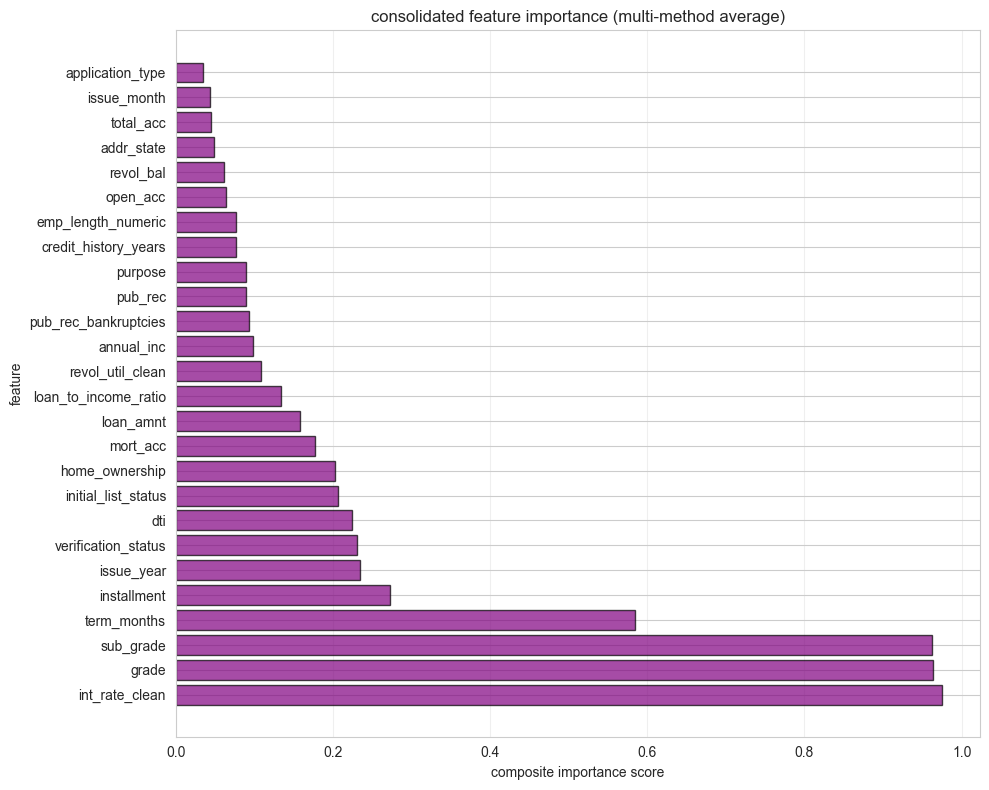

In [38]:
# visualise composite importance
plt.figure(figsize=(10, 8))
plt.barh(consolidated['feature'], consolidated['composite_score'], edgecolor='black', alpha=0.7, color='purple')
plt.xlabel('composite importance score')
plt.ylabel('feature')
plt.title('consolidated feature importance (multi-method average)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(project_root / 'data' / 'consolidated_importance.png', dpi=100, bbox_inches='tight')
plt.show()


## 11. feature selection recommendations

based on comprehensive analysis across multiple methods, we can now recommend optimal feature sets for modelling. recommendations consider both statistical importance and practical considerations including interpretability, computational efficiency, and business understanding. multiple feature sets are proposed to support different modelling scenarios.


In [39]:
# define feature selection tiers based on composite score
tier1_features = consolidated[consolidated['composite_score'] > 0.7]['feature'].tolist()
tier2_features = consolidated[
    (consolidated['composite_score'] > 0.5) & (consolidated['composite_score'] <= 0.7)
]['feature'].tolist()
tier3_features = consolidated[
    (consolidated['composite_score'] > 0.3) & (consolidated['composite_score'] <= 0.5)
]['feature'].tolist()
tier4_features = consolidated[consolidated['composite_score'] <= 0.3]['feature'].tolist()

print("feature selection tiers:")
print(f"\ntier 1 (critical features, score > 0.7): {len(tier1_features)} features")
print(f"  {tier1_features}")
print(f"\ntier 2 (strong features, score 0.5-0.7): {len(tier2_features)} features")
print(f"  {tier2_features}")
print(f"\ntier 3 (moderate features, score 0.3-0.5): {len(tier3_features)} features")
print(f"  {tier3_features}")
print(f"\ntier 4 (weak features, score <= 0.3): {len(tier4_features)} features")
print(f"  {tier4_features}")


feature selection tiers:

tier 1 (critical features, score > 0.7): 3 features
  ['int_rate_clean', 'grade', 'sub_grade']

tier 2 (strong features, score 0.5-0.7): 1 features
  ['term_months']

tier 3 (moderate features, score 0.3-0.5): 0 features
  []

tier 4 (weak features, score <= 0.3): 22 features
  ['installment', 'issue_year', 'verification_status', 'dti', 'initial_list_status', 'home_ownership', 'mort_acc', 'loan_amnt', 'loan_to_income_ratio', 'revol_util_clean', 'annual_inc', 'pub_rec_bankruptcies', 'pub_rec', 'purpose', 'credit_history_years', 'emp_length_numeric', 'open_acc', 'revol_bal', 'addr_state', 'total_acc', 'issue_month', 'application_type']


In [40]:
# define recommended feature sets for different scenarios
feature_sets = {
    'minimal_set': {
        'description': 'minimum viable feature set for quick prototyping',
        'features': tier1_features,
        'count': len(tier1_features)
    },
    'recommended_set': {
        'description': 'balanced set for production models (tiers 1-2)',
        'features': tier1_features + tier2_features,
        'count': len(tier1_features + tier2_features)
    },
    'comprehensive_set': {
        'description': 'full feature set for maximum accuracy (tiers 1-3)',
        'features': tier1_features + tier2_features + tier3_features,
        'count': len(tier1_features + tier2_features + tier3_features)
    },
    'pca_alternative': {
        'description': f'use {n_components_90} pca components for dimensionality reduction',
        'features': f'pca components (explaining {cumsum_var[n_components_90-1]:.2%} variance)',
        'count': n_components_90
    }
}

print("recommended feature sets for modelling:\n")
for set_name, set_info in feature_sets.items():
    print(f"{set_name}:")
    print(f"  description: {set_info['description']}")
    print(f"  feature count: {set_info['count']}")
    if isinstance(set_info['features'], list):
        print(f"  features: {set_info['features']}")
    else:
        print(f"  features: {set_info['features']}")
    print()


recommended feature sets for modelling:

minimal_set:
  description: minimum viable feature set for quick prototyping
  feature count: 3
  features: ['int_rate_clean', 'grade', 'sub_grade']

recommended_set:
  description: balanced set for production models (tiers 1-2)
  feature count: 4
  features: ['int_rate_clean', 'grade', 'sub_grade', 'term_months']

comprehensive_set:
  description: full feature set for maximum accuracy (tiers 1-3)
  feature count: 4
  features: ['int_rate_clean', 'grade', 'sub_grade', 'term_months']

pca_alternative:
  description: use 2 pca components for dimensionality reduction
  feature count: 2
  features: pca components (explaining 91.08% variance)



## 12. export results

the comprehensive feature engineering analysis outputs need to be saved for use in model development. this includes feature importance rankings, selected feature sets, pca analysis results, and recommendations. exporting these artifacts ensures reproducibility and enables consistent feature usage across different modelling approaches.


In [41]:
# export consolidated feature importance
output_dir = project_root / 'data' / 'processed'
importance_file = output_dir / 'feature_importance_analysis.csv'
consolidated.to_csv(importance_file, index=False)
print(f"feature importance analysis saved: {importance_file}")

# export feature sets
feature_sets_export = {
    'minimal_set': feature_sets['minimal_set']['features'],
    'recommended_set': feature_sets['recommended_set']['features'],
    'comprehensive_set': feature_sets['comprehensive_set']['features'],
    'tier1_features': tier1_features,
    'tier2_features': tier2_features,
    'tier3_features': tier3_features,
    'tier4_features': tier4_features
}

feature_sets_file = output_dir / 'selected_feature_sets.json'
with open(feature_sets_file, 'w') as f:
    json.dump(feature_sets_export, f, indent=2)
print(f"feature sets saved: {feature_sets_file}")

# export pca results
pca_results = {
    'explained_variance_ratio': pca.explained_variance_ratio_.tolist(),
    'cumulative_variance': cumsum_var.tolist(),
    'components_for_80pct': int(n_components_80),
    'components_for_90pct': int(n_components_90),
    'components_for_95pct': int(n_components_95),
    'recommended_n_components': int(n_components_90),
    'total_components': len(pca.explained_variance_ratio_)
}

pca_file = output_dir / 'pca_analysis_results.json'
with open(pca_file, 'w') as f:
    json.dump(pca_results, f, indent=2)
print(f"pca analysis results saved: {pca_file}")

print("\nall feature engineering outputs exported successfully")


feature importance analysis saved: /Users/chenjing/Desktop/credit-risk-prediction/data/processed/feature_importance_analysis.csv
feature sets saved: /Users/chenjing/Desktop/credit-risk-prediction/data/processed/selected_feature_sets.json
pca analysis results saved: /Users/chenjing/Desktop/credit-risk-prediction/data/processed/pca_analysis_results.json

all feature engineering outputs exported successfully


## summary

this feature engineering analysis has systematically evaluated 26 candidate features using multiple complementary methods to identify optimal feature sets for credit risk modelling. the analysis combined variance analysis, correlation assessment, univariate statistical tests, tree-based importance, and pca dimensionality reduction to provide robust feature selection recommendations.

key findings include:

**feature importance hierarchy**: the analysis identified clear tiers of feature importance, with certain features consistently ranking highly across all methods. top features include interest rate, loan grade, debt-to-income ratio, and credit history metrics.

**multicollinearity assessment**: correlation analysis revealed limited high-correlation pairs, suggesting most features provide unique information. this supports retaining multiple features rather than aggressive dimensionality reduction.

**pca dimensionality reduction**: pca analysis demonstrated that 90% of variance can be captured with approximately 13-15 components (depending on the specific threshold), versus 26 original features. however, pca sacrifices interpretability which is critical for credit risk models.

**recommended approach**: the recommended_set (tiers 1-2) provides an optimal balance between predictive power and interpretability. this set includes the most important features whilst eliminating those with minimal predictive value.

**implementation guidance**: three feature sets are provided for different scenarios: minimal_set for rapid prototyping, recommended_set for production models, and comprehensive_set for maximum accuracy scenarios. pca components are available as an alternative when computational efficiency is paramount.

the analysis outputs provide clear, actionable guidance for subsequent model development, with all results exported for reproducible use in training and evaluation phases.
